In [3]:
import numpy as np
import os
import pandas as pd
import geopandas as gpd
import ConfigParser

In [6]:
def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                DebugPrint("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1

In [5]:
Config.read('sabre_out_config.ini')
sabre_out_dir = ConfigSectionMap('directories')['sabre_out_dir']
output_dir = ConfigSectionMap('directories')['output_dir']
output_text = ConfigSectionMap('outputs')['output_text']
output_shp = ConfigSectionMap('outputs')['output_shp']

sabre_out_fls = os.listdir(sabre_out_dir)
sabre_ITS_path = os.sep.join([sabre_out_dir,[s for s in sabre_out_fls if "_ITS.txt" in s][0]])
sabre_ITS = pd.read_csv(sabre_ITS_path,sep=',')

best_est_name = sabre_ITS.Trial_Name[sabre_ITS.Trial_Name.str.contains("BestEstimate")][0]
print('Loading Best Estimate')
SABRE_all_trails = gpd.read_file(os.sep.join([sabre_out_dir,'Results',best_est_name+'_grid.shp']))
SABRE_all_trails['Trial_Name'] = best_est_name
SABRE_all_trails['Time'] = pd.to_datetime(sabre_ITS.Ignition_Time[sabre_ITS.Trial_Name.str.contains("BestEstimate")][0])

#Make a copy of dataframe where spotting exists
spot = SABRE_all_trails.dropna(subset = ['HOUR_SPOT']).copy()
spot['Grid_Type'] = 'Spot'
spot['Time'] = spot['Time'] + [pd.Timedelta(hours=ts) for ts in spot['HOUR_SPOT']]

#Trim trial
SABRE_all_trails = SABRE_all_trails.dropna(subset = ['HOUR_BURNT'])
SABRE_all_trails['Grid_Type'] = 'Fire'
SABRE_all_trails['Time'] = SABRE_all_trails['Time'] + [pd.Timedelta(hours=ts) for ts in SABRE_all_trails['HOUR_BURNT']]

#Recombine
SABRE_all_trails = pd.concat([SABRE_all_trails,spot])

del spot

for trial_name in sabre_ITS.Trial_Name[sabre_ITS.Trial_Name.str.contains("Trial")]:
    SABRE_trial = gpd.read_file(os.sep.join([sabre_out_dir,'Results',trial_name+'_grid.shp']))
    SABRE_trial['Time'] = pd.to_datetime(sabre_ITS.Ignition_Time[sabre_ITS.Trial_Name == trial_name])
    
    #Make a copy of dataframe where spotting exists
    spot = SABRE_trial.dropna(subset = ['HOUR_SPOT']).copy()
    spot['Grid_Type'] = 'Spot'
    spot['Time'] = spot['Time'] + [pd.Timedelta(hours=ts) for ts in spot['HOUR_SPOT']]
    
    #Trim trial
    SABRE_trial = SABRE_trial.dropna(subset = ['HOUR_BURNT'])
    SABRE_trial['Grid_Type'] = 'Fire'
    SABRE_trial['Time'] = SABRE_trial['Time'] + [pd.Timedelta(hours=ts) for ts in SABRE_trial['HOUR_BURNT']]
    
    SABRE_trial = pd.concat([SABRE_trial,spot])
    SABRE_trial['Trial_Name'] = trial_name
    #print(SABRE_trial['Trial_Name'].shape)
    print('Joining '+ trial_name)
    #print(SABRE_trial.shape[0])
    del spot
    SABRE_all_trails = pd.concat([SABRE_all_trails,SABRE_trial])
    #print(SABRE_all_trails.shape[0])
    del SABRE_trial
    
SABRE_all_trails['Time_obj'] = SABRE_all_trails['Time']
SABRE_all_trails['Time'] = SABRE_all_trails['Time'].astype(str)

if output_shp:
    
    print('Saving shapefile as ' + os.path.basename(sabre_out_dir) + 'all_trials.shp')
    if 'Time_obj' in SABRE_all_trails:
        trials_out = SABRE_all_trails.drop('Time_obj', axis=1)
    else:
        trials_out = SABRE_all_trails
    trials_out.to_file(os.sep.join([output_dir, os.path.basename(sabre_out_dir)]) + 'all_trials.shp',driver='ESRI Shapefile')

if output_text:
    SABRE_all_trails['Centriods'] = SABRE_all_trails.centroid.to_crs({'init': 'epsg:4326'})
    df = SABRE_all_trails.drop('geometry', axis=1)  # df is a DataFrame, not GeoDataFrame after the drop
    df['Latitude'] = SABRE_all_trails['Centriods'].apply(lambda p: p.x)
    df['Longitude'] = SABRE_all_trails['Centriods'].apply(lambda p: p.x)
    if 'Time_obj' in df:
        df = df.drop('Time_obj', axis=1)
    df = df.drop('Centriods', axis=1)
    df = df.drop('WIND_MOD', axis=1)
    print('Saving csv as ' + os.path.basename(sabre_out_dir) + 'all_trials.txt')
    df.to_csv(os.sep.join([output_dir, os.path.basename(sabre_out_dir)]) + 'all_trials.txt',index=False) #,float_format='%.1f'

Loading Best Estimate
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_1
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_2
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_3
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_4
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_5
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_6
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_7
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_8
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_9
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_10
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_11
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_12
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_13
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_14
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_15
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_16
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_17
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_18
Joining Rand_Sedgerly_5Dec_Ignto1215Scar_Trial_19
Joining Rand_Sedgerly_5Dec_Ignto1215S

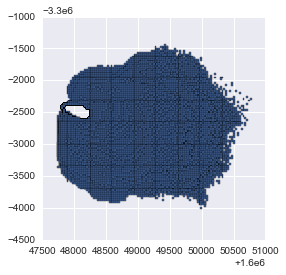

In [80]:
SABRE_all_trails.plot()

In [6]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

In [ ]:
with sns.axes_style('white'):
    g = sns.jointplot("split_sec", "final_sec", data, kind='hex')

In [8]:
spark_geotiff = './files_in/CustomOutputs.tiff'

In [188]:
def tiff2gpd(layer,layer_name,src):
    image = src.read(key) # first band
    results = (
    {'properties': {layer_name: v}, 'geometry': s}
    for k, (s, v) 
    in enumerate(
        shapes(image, mask=mask, transform=src.affine)))
    geoms = list(results)
    gdata  = gpd.GeoDataFrame.from_features(geoms)
    return gdata
    

raster_shapes = gpd.GeoDataFrame()
raster_shapes['geometry'] = None
field_dict = {1:'Fuel_type',
              2:'Flame_Height',
              3:'Crowning_Index',
              4:'ROS',
              5:'Time',
             }
raster_shapes['value'] = None
mask = None
band = 5 # 5 = Time of arrival
k = 0

with rasterio.drivers():
    with rasterio.open(spark_geotiff) as src:
        spark_polygons = tiff2gpd(5,'Time',src)
        for key, value in field_dict.iteritems():
            if value == 'Time':
                continue
            else:
                gdata = tiff2gpd(key,value,src)
                spark_polygons = gpd.sjoin(spark_polygons,gdata, how = 'left')

        spark_polygons.crs = src.crs

        

ValueError: 'index_left' and 'index_right' cannot be names in the frames being joined

In [ ]:
spark_polygons.head()

In [176]:
for key, value in field_dict.iteritems():
    print(key)

1
2
3
4
5


In [127]:
field_dict[1]

'Time of Arrival'

In [99]:
raster_shapes[raster_shapes.value==0]

,geometry,value
1653,"POLYGON ((1647797.625 -3302053, 1647797.625 -3...",0
1741,"POLYGON ((1647737.625 -3302083, 1647737.625 -3...",0
1830,"POLYGON ((1647707.625 -3302113, 1647707.625 -3...",0
1922,"POLYGON ((1647677.625 -3302143, 1647677.625 -3...",0
2014,"POLYGON ((1647647.625 -3302173, 1647647.625 -3...",0
2106,"POLYGON ((1647617.625 -3302203, 1647617.625 -3...",0
2603,"POLYGON ((1650017.625 -3302353, 1650017.625 -3...",0
2687,"POLYGON ((1650047.625 -3302383, 1650047.625 -3...",0
2773,"POLYGON ((1650077.625 -3302413, 1650077.625 -3...",0
2862,"POLYGON ((1650107.625 -3302443, 1650107.625 -3...",0


In [87]:
raster_shapes.to_file(os.sep.join([output_dir,'spark_vectorized.shp']),driver='ESRI Shapefile')

## Print legacy output fields 

In [161]:
tableau_out = pd.read_csv('./files_in/SABRE_results/Rand_Sedgerly_5Dec_Ignto1215Scar_2016125/Archived_Files/Output_tableau.txt')
tableau_out.keys()

Index([u'OBJECTID', u'CELL_ID', u'S_SLOPE', u'S_ELEVTN', u'S_ASPECT',
       u'F_GRASS', u'F_SURFACE', u'F_BARK', u'F_ELVTD', u'F_TOTAL',
       u'ROAD_PROX', u'DISRUPTION', u'HOUR_BURNT', u'E_ROS', u'E_INTSTY',
       u'HOUR_SPOT', u'SPOT_DIST', u'EMBR_DNSTY', u'SUPPRESSED', u'WENT_OUT',
       u'FLAME_HT', u'FLAME_DT', u'CONVECT', u'FMC', u'FFDI', u'ASSET_ID',
       u'WIND_SPD', u'WIND_DIR', u'IMPACT_DIR', u'HL_PROB', u'X_COORD',
       u'Y_COORD', u'Trial', u'Grid_Type', u'Trial_count_total',
       u'Incident_Name', u'Incident_Identifier', u'State', u'Supported_Agency',
       u'Region', u'Requesting_Group', u'Scenario_Name', u'Scenario_Type',
       u'Scenario_Description', u'Trial_Name', u'Ignition_Time', u'Simulator',
       u'Prediction_Valid_Until', u'Trial_Count', u'Simulated_Grid_Size_m',
       u'Requesting_Person', u'Requesting_Person_Phone',
       u'Requesting_Person_Email', u'FBAN', u'FBAN_Phone', u'FBAN_Email',
       u'Authorising_FBAN', u'Authorising_FBAN_Phone',
  

## Print out possible drivers for Geopandas

In [54]:
import fiona; fiona.supported_drivers

{'ARCGEN': 'r',
 'AeronavFAA': 'r',
 'BNA': 'raw',
 'DGN': 'raw',
 'DXF': 'raw',
 'ESRI Shapefile': 'raw',
 'GPKG': 'rw',
 'GPSTrackMaker': 'raw',
 'GPX': 'raw',
 'GeoJSON': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'OpenFileGDB': 'r',
 'PCIDSK': 'r',
 'SEGY': 'r',
 'SUA': 'r'}